In [1]:
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from astropy.constants import G
from galpy.potential import TwoPowerSphericalPotential, plotPotentials, evaluateDensities, plotRotcurve
from galpy.util import conversion
import galpy.potential as gp
from galpy.orbit import Orbit

In [2]:
data = h5py.File("cutout_598597.hdf5", 'r')

In [3]:
data['PartType1']['SubfindDensity'][:10]
h = data['Header'].attrs['HubbleParam']
m = data['Header'].attrs['MassTable'][1]  / h * u.solMass * 10**10
a = data['Header'].attrs['Time']
l = data['Header'].attrs['BoxSize']


print(h)
print(m)
print(a)
print(l)

0.6774
538464.1418081385 solMass
0.9999999999999998
35000.0


In [4]:
coords = data['PartType1']['Coordinates'][:] / h
velocities = data['PartType1']['Velocities'][:]



In [5]:
def pot_x(x, coord): 
    x_n = np.array([x])
    x_i = np.repeat(x_n, len(coord), axis=0)
    return np.sum((- G*m /np.sqrt(np.sum((x_i - coord)**2, axis=1)) / u.kpc).to(u.m**2 / u.s**2))

In [6]:
l = data['Header'].attrs['BoxSize'] / h

com_coord = np.sum(coords,axis=0) / len(coords)
coords_centred = coords - com_coord
com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

r_min = np.min(com_dist)
r_max = np.max(com_dist)

x_ = np.linspace(0, l, 10)
y_ = np.linspace(0, l, 10)
z_ = np.linspace(0, l, 10)
potential_points = []
rs = []

for x in x_:
    for y in y_:
        for z in z_:
            potential_points.append(pot_x(np.array([x, y, z]), coords) * u.s**2 / u.m**2 / 1000)
            
            rs.append(np.sqrt((x - com_coord[0])**2 + (y - com_coord[1])**2 + (z - com_coord[2])**2))

In [7]:
axes_size = np.max(coords_centred, axis=0) - np.min(coords_centred, axis=0)
triax_par = (axes_size[1]**2 - axes_size[2]**2) / (axes_size[1]**2 - axes_size[0]**2)
print(triax_par)
print(axes_size[0]/ axes_size[1])

0.8127406609233666
0.6536388833936412


In [8]:
# Define grid
x_ = np.linspace(-2*r_max, 2*r_max, 50)
y_ = np.linspace(-2*r_max, 2*r_max, 50)
z_mid = com_coord[2]  # choose midplane

# Create empty array for potentials
potential_xy = np.zeros((len(y_), len(x_)))

# Compute potential on xy-plane at z=z_mid
for i, x in enumerate(x_):
    for j, y in enumerate(y_):
        r = np.array([x, y, z_mid])
        potential_xy[j, i] = pot_x(r, coords_centred) * u.s**2 / u.m**2  # assume returns scalar potential

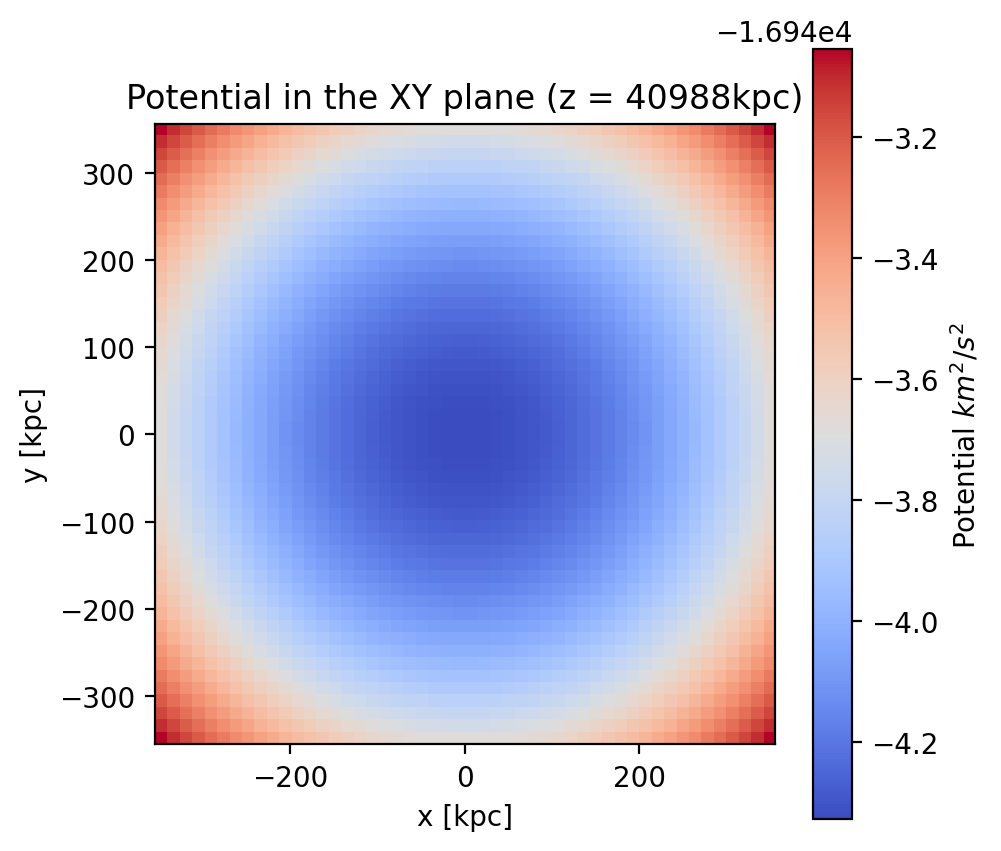

In [25]:
# Plot colormap
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(potential_xy / 1000, origin='lower', extent=[-2*r_max, 2*r_max, -2*r_max, 2*r_max], cmap='coolwarm')
plt.colorbar(label=r'Potential $km^2/s^2$')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Potential in the XY plane (z = {:.0f}kpc)'.format(z_mid))

plt.savefig('pot_xy')
plt.show()


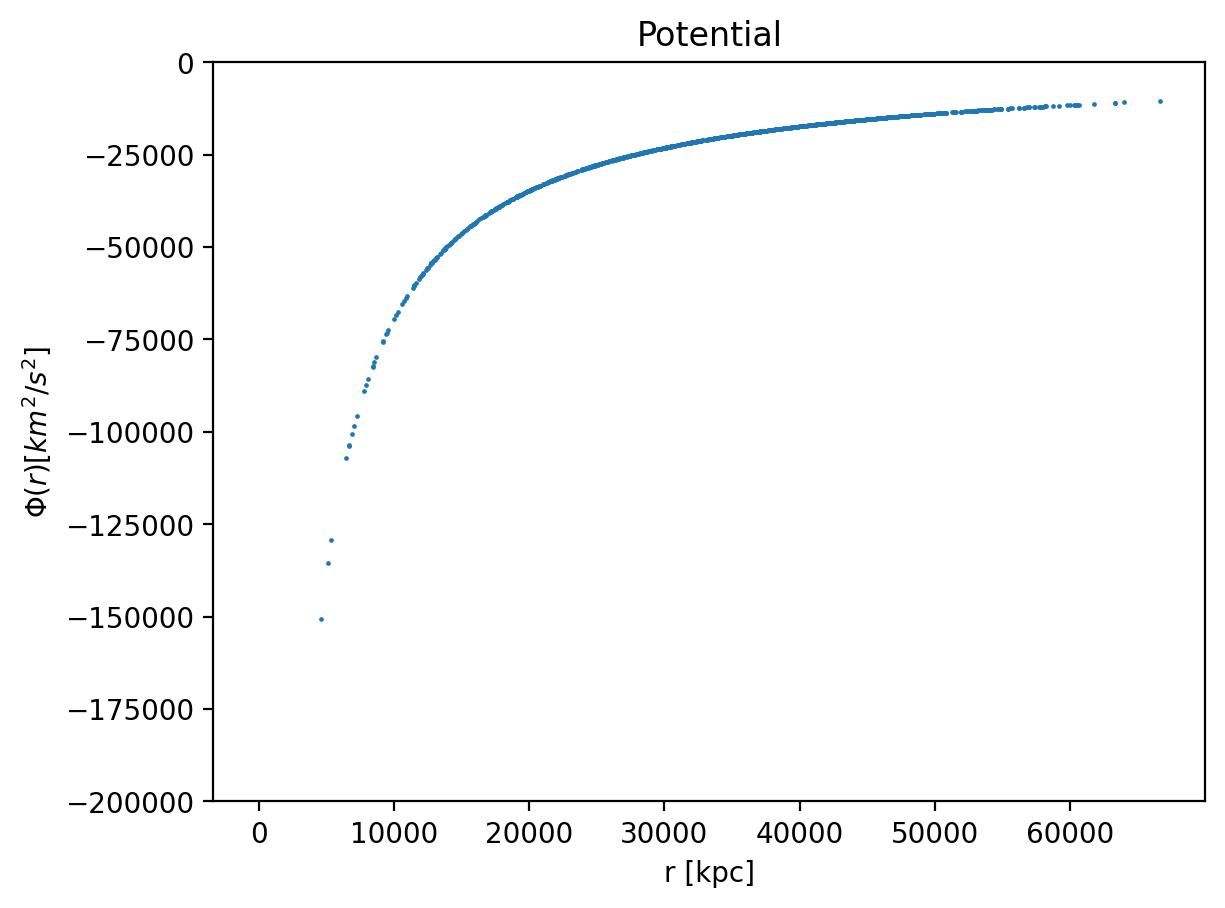

In [29]:

a_galpy = 6.502117092241845
ampl_galpy = 161.47893455855902 * 10 **9    # convert to galpy units

Phi = TwoPowerSphericalPotential(amp=ampl_galpy, a=a_galpy, alpha=0.5615083234443553, beta=3.2455530875569636)
r = np.linspace(1, 60000, 1000)
phi_vals = [Phi(r_i, 0)for r_i in r]
fig, ax = plt.subplots(dpi=200)
ax.plot(r/ u.kpc, phi_vals)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Phi(r) [km^2/s^2]$")
plt.title("Potential")
ax.set_ylim(-2*10**5, 0)
ax.scatter(rs, potential_points, s = 0.5)
plt.savefig('pot')
plt.show()

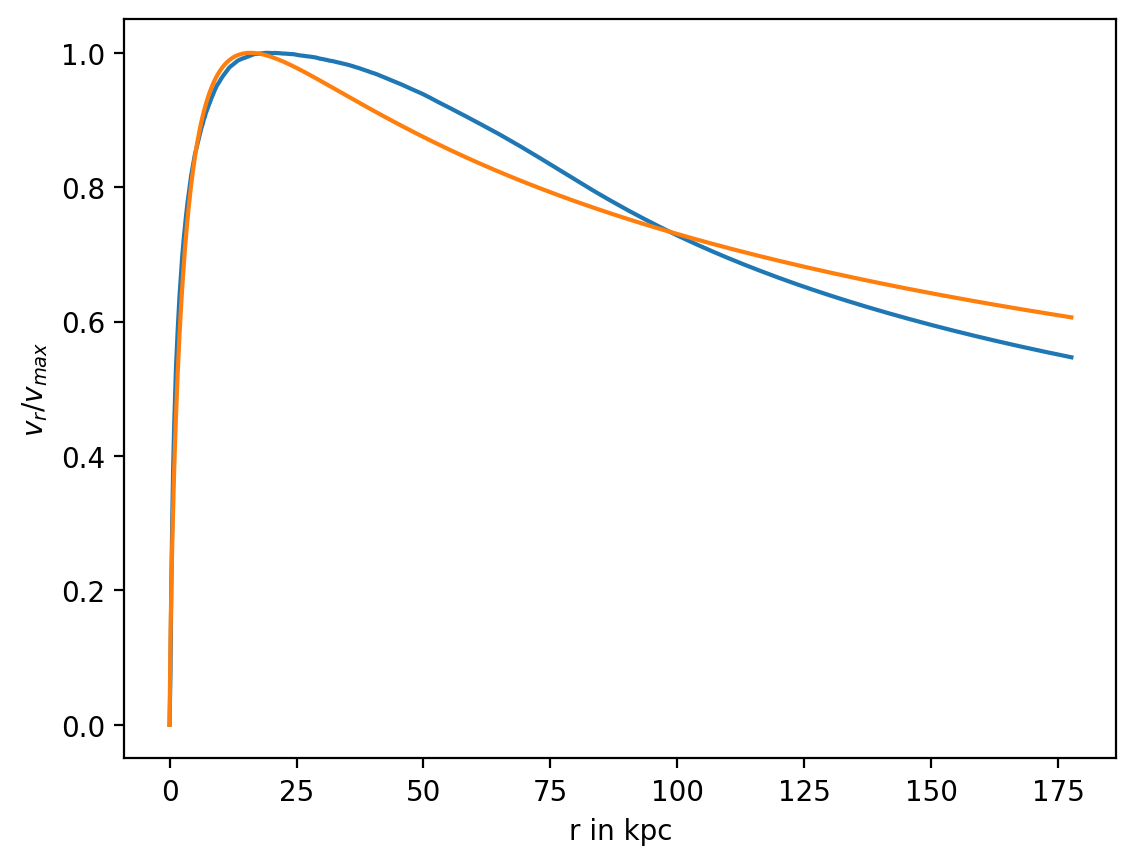

In [27]:
R = np.linspace(0.0000001, r_max, 1000)
v_s = np.zeros(len(rs))
v_s_m = np.zeros(len(rs))
i = 0
for r in R:
    masses = (com_dist < r).sum()
    v_s[i] = (np.sqrt(G * m * masses /(r * u.kpc)).to(u.km/u.s))*u.s /u.km
    v_s_m[i] = gp.vcirc(Phi, r)
    i += 1

v_max = np.max(v_s)
V_max = np.max(v_s_m)
fig, ax = plt.subplots(dpi=200)
ax.plot(R, v_s/ v_max)
ax.plot(R, v_s_m / V_max)
ax.set_ylabel(r'$v_r/ v_{max}$')
ax.set_xlabel('r in kpc')
plt.savefig('rotc')
plt.show()

In [12]:
dens = evaluateDensities(Phi, r, 0, phi=None, t=0.0, forcepoisson=False)

In [13]:
def doublepowerlaw(r_kpc, ampl_solm, a_kpc, alpha, beta):
    constant = ampl_solm/(4*np.pi*(a_kpc**3))
    density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
    return density

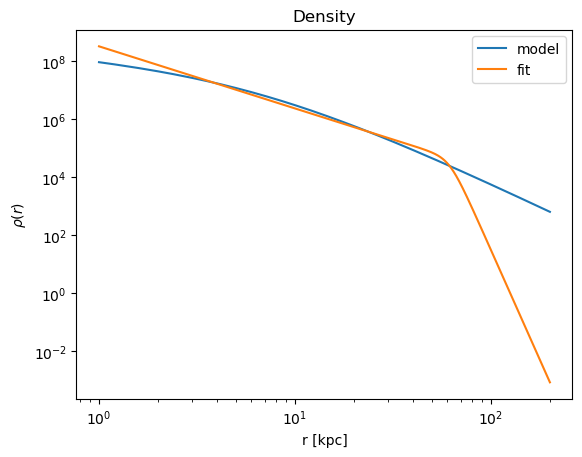

In [14]:
r = np.linspace(1, 200, 1000)
dens_vals = [doublepowerlaw(r_i, 1.408539e+11, 61.59979773,2.137631284420001, 15.157640182989251) for r_i in r]
dens = evaluateDensities(Phi, r, 0, phi=None, t=0.0, forcepoisson=False)
fig,ax = plt.subplots()
ax.plot(r/ u.kpc, dens, label='model')
ax.plot(r/ u.kpc, dens_vals, label='fit')
plt.xlabel("r [kpc]")
plt.ylabel(r"$\rho(r)$")
plt.title("Density")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

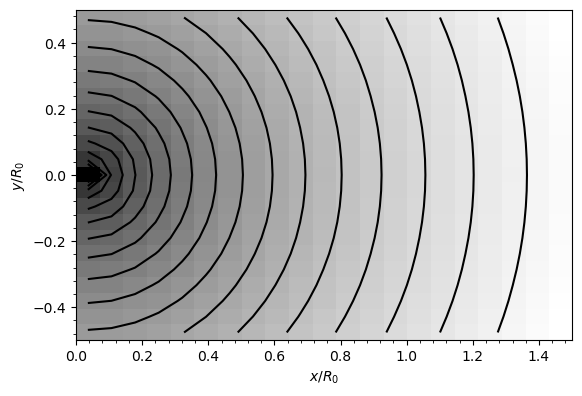

In [15]:
Phi.plotSurfaceDensity()

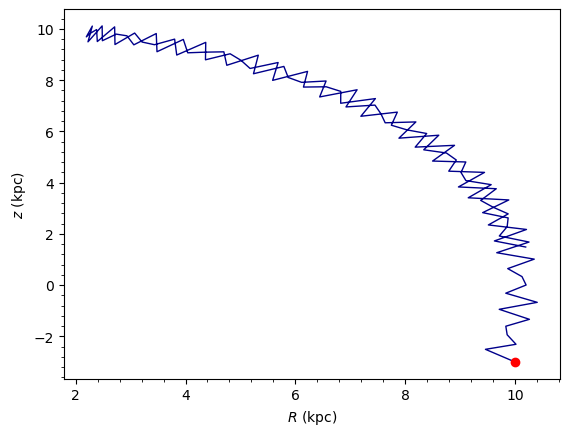

In [16]:


o2 = Orbit([10*u.kpc, 100*u.km/u.s, 17*u.km/u.s, -3*u.kpc, 45*u.km/u.s, 6*u.rad])
ts = np.linspace(0.,2,100)*u.Gyr
o2.integrate(ts,Phi)

o2.plot(lw=1, c='darkblue');
plt.plot([o2.R().to_value()],[o2.z().to_value()],'ro');

In [18]:

# coords, velocities: shape (3, N)
x, y, z = np.transpose(coords_centred)
vx, vy, vz = np.transpose(velocities)

r = x**2 + y**2 + z**2
# Radial unit vectors
# Avoid division by zero at r=0 by adding a small epsilon
eps = 1e-12
rx = x / (r + eps)
ry = y / (r + eps)
rz = z / (r + eps)

# Radial velocity (projection of v onto r-hat)
v_r = vx * rx + vy * ry + vz * rz

#Number of radial bins
nbins = 40

# --- Equal-number binning ---
# Sort by radius
idx = np.argsort(r)
r_sorted = r[idx]
v_r_sorted = v_r[idx]

# Split into equal chunks
r_chunks = np.array_split(r_sorted, nbins)
v_chunks = np.array_split(v_r_sorted, nbins)

# Compute bin centers and dispersions
r_centers = np.array([chunk.mean() for chunk in r_chunks])

v_r_m = gp.vcirc(Phi, r_centers)
sigma_r = np.array([
    np.sqrt(chunk_vr.mean()**2 * 0 +   # trick to keep dtype
            (np.mean(chunk_vr**2) - np.mean(chunk_vr)**2))
    for chunk_vr in v_chunks
])


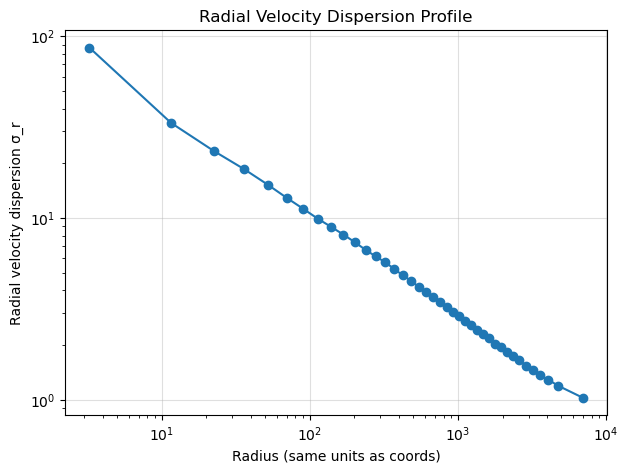

In [28]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(r_centers, sigma_r, marker='o', lw=1.5)
plt.xlabel("Radius (same units as coords)")
plt.ylabel("Radial velocity dispersion σ_r")
plt.title("Radial Velocity Dispersion Profile")
plt.grid(True, alpha=0.4)
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)
plt.savefig('v_disp')
plt.show()
